<a href="https://colab.research.google.com/github/ayshaw/complexCorrection/blob/master/notebooks/GREMLIN_TF_v2_weights_edit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GREMLIN_TF v2.1
GREMLIN implemented in tensorflow

### Change log:
*   02Apr2019
 - fixing a few hard-coded values, to allow GREMLIN to work with any alphabet (binary, protein, rna etc)
*   22Jan2019
 - moving [GREMLIN_TF_simple](https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF_simple.ipynb) to a seperate notebook
*   19Jan2019
 - in the past we found that optimizing V first, required less iterations for convergence. Since V can be computed exactly (assuming no W), we replace this first optimization step with a simple V initialization.
 - a few variables were renamed to be consistent with the c++ version
*   16Jan2019
 - updating how indices are handled (for easier/cleaner parsing)
 - minor speed up in how we symmetrize and zero the diagional of W
*   15Jan2019
 - LBFGS optimizer replaced with a modified version of the ADAM optimizer
 - Added option for stochastic gradient descent (via batch_size)
  
### Method:
GREMLIN takes a multiple sequence alignment (MSA) and returns a Markov Random Field (MRF). The MRF consists of a one-body term (V) that encodes conservation, and a two-body term (W) that encodes co-evolution.

For more details about the method see:
[Google slides](https://docs.google.com/presentation/d/1aooxoksosSv7CWs9-ktqhUjyXR3wrgbG5a6PCr92od4/) and accompanying [Google colab](https://colab.research.google.com/drive/17RJcExuyifnd7ShTcsZGh6mBpWq0-s60)

See [GREMLIN_TF_simple](https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF_simple.ipynb) for a stripped down version of this code (with no funky gap removal, sequence weight, etc). This is intented for educational purpose,  and could also be very useful for anyone trying to modify or improve the algorithm!


In [0]:
# ------------------------------------------------------------
# "THE BEERWARE LICENSE" (Revision 42):
# <so@g.harvard.edu> and <pkk382@g.harvard.edu> wrote this code.
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy us a beer in return.
# --Sergey Ovchinnikov and Peter Koo
# ------------------------------------------------------------

In [0]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip

In [0]:
# LOG_DIR = './log'
# get_ipython().system_raw(
#     'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#     .format(LOG_DIR)
# )

In [0]:
# get_ipython().system_raw('./ngrok http 6006 &')


In [0]:
# ! curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

## libraries

In [0]:
# IMPORTANT, only tested using PYTHON 3!
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from scipy import stats
from scipy.spatial.distance import pdist,squareform
import pandas as pd
import os
import time
import pickle as pkl
#from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import multiprocessing as mp
from keras.callbacks import TensorBoard
tbCallBack = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         batch_size=None,
                         write_images=True)
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
os.chdir('/content/drive/My Drive/markslab/multimerCorrection')  
from scipy.spatial import distance
from multiprocessing import Pool,Process
import psutil
!ls



Using TensorFlow backend.


In [0]:
!ls datasets

4FAZA.fas	allpdb0777_evcouplings.a2m  wb_ini
allpdb0148.a2m	allpdb0777_reduced.a2m


## Params

In [0]:
################
# note: if you are modifying the alphabet
# make sure last character is "-" (gap)
################
alphabet = "ARNDCQEGHILKMFPSTWYV-"
states = len(alphabet)
a2n = {}
for a,n in zip(alphabet,range(states)):
    a2n[a] = n
################

def aa2num(aa):
    '''convert aa into num'''
    if aa in a2n: return a2n[aa]
    else: return a2n['-']

## Functions for prepping the MSA (Multiple sequence alignment)

In [0]:
from functools import partial
# from fasta
def parse_fasta(filename,limit=-1):
    '''function to parse fasta'''
    header = []
    sequence = []
    lines = open(filename, "r")
    for line in lines:
        line = line.rstrip()
        if line[0] == ">":
            if len(header) == limit:
                break
            header.append(line[1:])
            sequence.append([])
        else:
            sequence[-1].append(line)
    lines.close()
    sequence = [''.join(seq) for seq in sequence]
    return np.array(header), np.array(sequence)

def filt_gaps(msa,gap_cutoff=0.5):
    '''filters alignment to remove gappy positions'''
    tmp = (msa == states-1).astype(np.float)
    non_gaps = np.where(np.sum(tmp.T,-1).T/msa.shape[0] < gap_cutoff)[0]
    return msa[:,non_gaps],non_gaps

def get_eff(msa,eff_cutoff=0.8):
    '''compute effective weight for each sequence'''
    ncol = msa.shape[1]
    start = time.time()
    print('starting pdist!')
    # pairwise identity
    pdist_res = pdist(msa,"hamming") #need to sparsify this process
    #print('shape of pdist result before squareform: {}, sum of pdist: {}'.format(pdist(msa,'hamming').shape, np.sum(pdist(msa,'hamming'))))
    msa_sm = 1.0 - squareform(pdist(msa,"hamming")) #need to sparsify this process
    #print('finished hamming: {} seconds \t shape of msa_sm after squareform: {}'.format(time.time()-start,msa_sm.shape))
    # weight for each sequence
    msa_w = (msa_sm >= eff_cutoff).astype(np.float64)
    print(msa_w)
    #print('shape of msa_w after cutoff: {}, \t sum of msa_w:{} \t shape of sum: {}'.format(msa_w.shape,np.sum(msa_w,-1),np.sum(msa_w,-1).shape))
    msa_w = 1/np.sum(msa_w,-1)
    #print('shape of weights after sum normalization: {}'.format(msa_w.shape))
    return msa_w
  
def f(msa,i): 
  rncol=(1/(msa.shape[1]))
  return 1/(np.sum(rncol*np.sum(msa==msa[i],axis=1,dtype=np.uint16)>=0.8,dtype=np.uint32))

# def get_eff_lowmem(msa):
#   msa = np.uint8(msa)
#   nrow=np.uint32(msa.shape[0])
#   processes = [mp.Process(target = f, args=(msa,i)) for i in range(nrow)]
#   for p in processes:
#     p.start()

#   for p in processes:
#     p.join()
#   return processes
# def get_eff_lowmem(msa):
#   msa = np.uint8(msa)
#   nrow=np.uint32(msa.shape[0])
#   pool=mp.Pool(processes=1)
#   return list(pool.map(partial(f,msa),range(nrow)))    
# from multiprocessing import Process, Value, Array

# def f(m,i,eff_cutoff=0.8):
#     rncol=1/m.shape[1]
#     return (np.sum(rncol*np.sum(m==m[i,:],axis=1)>=eff_cutoff))
# # import multiprocessing as mp
def get_eff_lowmem(msa,eff_cutoff=0.8):
  pool = mp.Pool(processes=1)
  return np.fromiter(pool.map(partial(f,msa),np.arange(msa.shape[0])),dtype=float)
  


# def cluster(msa, method='ward', threshold=0.8):
#     Z = linkage(1-squareform(pdist(msa,"hamming")),method) 
#     return fcluster(Z,threshold,criterion='distance')
def mk_msa(seqs):
    '''converts list of sequences to msa'''

    msa_ori = []
    for seq in seqs:
        msa_ori.append(list(map(aa2num,seq)))
    msa_ori = np.array(msa_ori,dtype=np.int)
    start=time.time()
    # remove positions with more than > 50% gaps
    msa, v_idx = filt_gaps(msa_ori,0.5)
    # compute effective weight for each sequence
    
    start = time.time()
    msa_weights = get_eff_lowmem(msa)
    ncol = msa.shape[1] # length of sequence
    w_idx = v_idx[np.stack(np.triu_indices(ncol,1),-1)]
    return {"msa_ori": msa_ori,
          "msa":msa,
          "weights":msa_weights,
          "neff":np.sum(msa_weights),
          "nrow":msa.shape[0],
          "ncol":ncol,
         "w_idx":w_idx,
         "v_idx":v_idx}


In [0]:

# process input sequences
names, seqs = parse_fasta("datasets/allpdb0777_reduced.a2m")
msa = mk_msa(seqs)

In [0]:
wb_input = np.loadtxt('datasets/wb_ini/allpdb0777_wb_ini.txt')
wb_input_ones = np.ones_like(wb_input)

## GREMLIN

In [0]:
# external functions

def sym_w(w):
    '''symmetrize input matrix of shape (x,y,x,y)'''
    x = w.shape[0]
    w = w * np.reshape(1-np.eye(x),(x,1,x,1))
    w = w + tf.transpose(w,[2,3,0,1])
    return w

def opt_adam(loss, name, var_list=None, lr=1.0, b1=0.9, b2=0.999, b_fix=False):
    # adam optimizer
    # Note: this is a modified version of adam optimizer. More specifically, we replace "vt"
    # with sum(g*g) instead of (g*g). Furthmore, we find that disabling the bias correction
    # (b_fix=False) speeds up convergence for our case.

    if var_list is None: var_list = tf.trainable_variables() 
    gradients = tf.gradients(loss,var_list)
    if b_fix: t = tf.Variable(0.0,"t")
    opt = []
    for n,(x,g) in enumerate(zip(var_list,gradients)):
        if g is not None:
            ini = dict(initializer=tf.zeros_initializer,trainable=False)
            mt = tf.get_variable(name+"_mt_"+str(n),shape=list(x.shape), **ini)
            vt = tf.get_variable(name+"_vt_"+str(n),shape=[], **ini)

            mt_tmp = b1*mt+(1-b1)*g
            vt_tmp = b2*vt+(1-b2)*tf.reduce_sum(tf.square(g))
            lr_tmp = lr/(tf.sqrt(vt_tmp) + 1e-8)

            if b_fix: lr_tmp = lr_tmp * tf.sqrt(1-tf.pow(b2,t))/(1-tf.pow(b1,t))

            opt.append(x.assign_add(-lr_tmp * mt_tmp))
            opt.append(vt.assign(vt_tmp))
            opt.append(mt.assign(mt_tmp))

    if b_fix: opt.append(t.assign_add(1.0))
    return(tf.group(opt))

In [0]:
def GREMLIN_weights(msa, wb_input=wb_input,opt_type="adam", opt_iter=100, opt_rate=1.0, batch_size=512):
  
    ##############################################################
    # SETUP COMPUTE GRAPH
    ##############################################################
    # kill any existing tensorflow graph
    tf.reset_default_graph()

    ncol = msa["ncol"] # length of sequence
    nrow = msa["nrow"] # number of sequences
    print("ncol: {},n nrow: {}".format(ncol,nrow))

    # msa (multiple sequence alignment) 
    MSA = tf.placeholder(tf.int32,shape=(None,ncol),name="msa")

    # one-hot encode msa
    OH_MSA = tf.one_hot(MSA,states)

    # msa weights
    MSA_weights = tf.placeholder(tf.float32, shape=(None,), name="msa_weights")
    idx = tf.placeholder(tf.int64,shape=[batch_size], name = 'idx')

    # 1-body-term of the MRF
    V = tf.get_variable(name="V", 
                      shape=[ncol,states],
                      initializer=tf.zeros_initializer)

    # 2-body-term of the MRF
    W = tf.get_variable(name="W",
                      shape=[ncol,states,ncol,states],
                      initializer=tf.zeros_initializer)

    # weights for concatenation
    wb = tf.get_variable(name="wb",
                      shape=[nrow],
                      initializer=tf.ones_initializer,
                      constraint=lambda x: tf.clip_by_value(x, 0, np.infty)
                      )
    wb=tf.math.multiply(wb,wb_input)
    # symmetrize W
    W = sym_w(W)

    def L2(x): return tf.reduce_sum(tf.square(x))
    def L1(x): return tf

    ########################################
    # V + W
    ########################################
    VW = V + tf.tensordot(OH_MSA,W,2)

    # hamiltonian
    H = tf.reduce_sum(tf.multiply(OH_MSA,VW),axis=(1,2))

    # local Z (parition function)
    Z = tf.reduce_sum(tf.reduce_logsumexp(VW,axis=2),axis=1)

    # Psuedo-Log-Likelihood
    PLL = H - Z
    wb = tf.nn.relu(wb)
    # Regularization
    L2_V = 0.01 * L2(V)
    L2_W = 0.01 * L2(W) * 0.5 * (ncol-1) * (states-1)
    L2_wb = 0.01 * L2(tf.gather(wb,idx))

    # loss function to minimize
    #loss = -tf.reduce_sum(PLL*MSA_weights*tf.gather(wb,idx))/tf.reduce_sum(MSA_weights*tf.gather(wb,idx))
    loss = -tf.reduce_sum(PLL*MSA_weights*tf.gather(wb,idx))/tf.reduce_sum(MSA_weights*tf.gather(wb,idx))-tf.minimum(tf.reduce_min(wb),0)
    loss = loss + (L2_V + L2_W + L2_wb)/msa["neff"]
    #wb = tf.nn.softmax(wb)
    ##############################################################
    # MINIMIZE LOSS FUNCTION
    ##############################################################
    if opt_type == "adam":  
        opt = opt_adam(loss,"adam",lr=opt_rate)

    # generate input/feed
    def feed(feed_all=False):
        if batch_size is None or feed_all:
            return {MSA:msa["msa"], MSA_weights:msa["weights"],idx:np.arange(len(msa['weights']))}
        else:
            idx_val = np.random.randint(0,msa["nrow"],size=batch_size)
            return {MSA:msa["msa"][idx_val], MSA_weights:msa["weights"][idx_val],idx:idx_val}

    # optimize!
    with tf.Session() as sess:
        # initialize variables V and W
        sess.run(tf.global_variables_initializer())
        feed_dict = feed()
        # initialize V
        msa_cat = tf.keras.utils.to_categorical(msa["msa"],states)
        pseudo_count = 0.01 * np.log(msa["neff"])
        V_ini = np.log(np.sum(msa_cat.T * msa["weights"],-1).T + pseudo_count)
        V_ini = V_ini - np.mean(V_ini,-1,keepdims=True)
        wb_ini = sess.run(wb)
        sess.run(V.assign(V_ini))

        

        # compute loss across all data
        get_loss = lambda: round(sess.run(loss,feed()) * msa["neff"],2)
        print("starting",get_loss())

#         if opt_type == "lbfgs":
#             lbfgs = tf.contrib.opt.ScipyOptimizerInterface
#             opt = lbfgs(loss,method="L-BFGS-B",options={'maxiter': opt_iter})
#             opt.minimize(sess,feed(feed_all=True))

        if opt_type == "adam":
            for i in range(opt_iter):
                sess.run(opt,feed())  
                if (i+1) % int(opt_iter/10) == 0:
                    print("iter",(i+1),get_loss())

        # save the V and W parameters of the MRF
        V_ = sess.run(V)
        W_ = sess.run(W)
        wb_ =sess.run(wb)

    # only return upper-right triangle of matrix (since it's symmetric)
    tri = np.triu_indices(ncol,1)
    W_ = W_[tri[0],:,tri[1],:]

    mrf = {"v": V_,
         "w": W_,
         "wb": wb_,
         "wb_ini":wb_ini,
          'w_idx':msa['w_idx'],
          'v_idx':msa['v_idx']}

    return mrf

In [0]:
def GREMLIN(msa, opt_type="adam", opt_iter=100, opt_rate=1.0, batch_size=None):

    ##############################################################
    # SETUP COMPUTE GRAPH
    ##############################################################
    # kill any existing tensorflow graph
    tf.reset_default_graph()

    ncol = msa["ncol"] # length of sequence

    # msa (multiple sequence alignment) 
    MSA = tf.placeholder(tf.int32,shape=(None,ncol),name="msa")

    # one-hot encode msa
    OH_MSA = tf.one_hot(MSA,states)

    # msa weights
    MSA_weights = tf.placeholder(tf.float32, shape=(None,), name="msa_weights")

    # 1-body-term of the MRF
    V = tf.get_variable(name="V", 
                      shape=[ncol,states],
                      initializer=tf.zeros_initializer)

    # 2-body-term of the MRF
    W = tf.get_variable(name="W",
                      shape=[ncol,states,ncol,states],
                      initializer=tf.zeros_initializer)

    # symmetrize W
    W = sym_w(W)

    def L2(x): return tf.reduce_sum(tf.square(x))

    ########################################
    # V + W
    ########################################
    VW = V + tf.tensordot(OH_MSA,W,2)

    # hamiltonian
    H = tf.reduce_sum(tf.multiply(OH_MSA,VW),axis=(1,2))

    # local Z (parition function)
    Z = tf.reduce_sum(tf.reduce_logsumexp(VW,axis=2),axis=1)

    # Psuedo-Log-Likelihood
    PLL = H - Z
    # Regularization
    L2_V = 0.01 * L2(V)
    L2_W = 0.01 * L2(W) * 0.5 * (ncol-1) * (states-1)


    # loss function to minimize
    loss = -tf.reduce_sum(PLL*MSA_weights)/tf.reduce_sum(MSA_weights)
    loss = loss + (L2_V + L2_W)/msa["neff"]

    ##############################################################
    # MINIMIZE LOSS FUNCTION
    ##############################################################
    if opt_type == "adam":  
        opt = opt_adam(loss,"adam",lr=opt_rate)

    # generate input/feed
    def feed(feed_all=False):
        if batch_size is None or feed_all:
            return {MSA:msa["msa"], MSA_weights:msa["weights"]}
        else:
            idx = np.random.randint(0,msa["nrow"],size=batch_size)
        return {MSA:msa["msa"][idx], MSA_weights:msa["weights"][idx]}

    # optimize!
    with tf.Session() as sess:
        # initialize variables V and W
        sess.run(tf.global_variables_initializer())

        # initialize V
        msa_cat = tf.keras.utils.to_categorical(msa["msa"],states)
        pseudo_count = 0.01 * np.log(msa["neff"])
        V_ini = np.log(np.sum(msa_cat.T * msa["weights"],-1).T + pseudo_count)
        V_ini = V_ini - np.mean(V_ini,-1,keepdims=True)
        sess.run(V.assign(V_ini))

        # compute loss across all data
        get_loss = lambda: round(sess.run(loss,feed(feed_all=True)) * msa["neff"],2)
        print("starting",get_loss())

        if opt_type == "lbfgs":
            lbfgs = tf.contrib.opt.ScipyOptimizerInterface
            opt = lbfgs(loss,method="L-BFGS-B",options={'maxiter': opt_iter})
            opt.minimize(sess,feed(feed_all=True))

        if opt_type == "adam":
            for i in range(opt_iter):
                sess.run(opt,feed())  
                if (i+1) % int(opt_iter/10) == 0:
                    print("iter",(i+1),get_loss())

        # save the V and W parameters of the MRF
        V_ = sess.run(V)
        W_ = sess.run(W)

    # only return upper-right triangle of matrix (since it's symmetric)
    tri = np.triu_indices(ncol,1)
    W_ = W_[tri[0],:,tri[1],:]

    mrf = {"v": V_,
         "w": W_,
              'w_idx':msa['w_idx'],
          'v_idx':msa['v_idx']}

    return mrf

## EXAMPLE

In [0]:
# download example fasta MSA
#!wget -q -nc https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4FAZA.fas
import time

In [0]:
# # ===============================================================================
# # PREP MSA
# # ===============================================================================
# # parse fasta
# start = time.time()
# names, seqs = parse_fasta("concatenate.a2m")
# print('finished parsing: {} seconds'.format(time.time()-start))
# # process input sequences
# msa = mk_msa(seqs)



In [0]:
# with open("names.txt", "w+") as output:
#     output.write(str(names.tolist()))
# print('finished writing')
# with open("seqs.txt", "w+") as output:
#     output.write(str(seqs.tolist()))

In [0]:
%%time
# ===============================================================================
# RUN GREMLIN
# ===============================================================================
# Note: the original GREMLIN uses the "lbfgs" optimizer which is EXTREMELY slow 
# in tensorflow. The modified adam optimizer is much faster, but may 
# require adjusting number of iterations (opt_iter) to converge to the same 
# solution. To switch back to the original, set opt_type="lbfgs".
# ===============================================================================
mrf_weights = GREMLIN_weights(msa,wb_input=wb_input_ones,opt_iter=150,batch_size=1024)

ncol: 160,n nrow: 26261
starting 791072.31
iter 15 343078.44
iter 30 253635.34
iter 45 221907.02
iter 60 210208.61
iter 75 211015.42
iter 90 206997.84
iter 105 174456.05
iter 120 198704.48
iter 135 187166.88
iter 150 173621.02
CPU times: user 4.61 s, sys: 1.48 s, total: 6.08 s
Wall time: 7.62 s


In [0]:

# %%time
# # ===============================================================================
# # RUN GREMLIN
# # ===============================================================================
# # Note: the original GREMLIN uses the "lbfgs" optimizer which is EXTREMELY slow 
# # in tensorflow. The modified adam optimizer is much faster, but may 
# # require adjusting number of iterations (opt_iter) to converge to the same 
# # solution. To switch back to the original, set opt_type="lbfgs".
# # ===============================================================================
# mrf = GREMLIN(msa)

## Explore the contact map
### Contact prediction:

For contact prediction, the W matrix is reduced from LxLx21x21 to LxL matrix (by taking the L2norm for each of the 20x20). In the code below, you can access this as mtx["raw"]. Further correction (average product correction) is then performed to the mtx["raw"] to remove the effects of entropy, mtx["apc"]. The relative ranking of mtx["apc"] is used to assess importance. When there are enough effective sequences (>1000), we find that the top 1.0L contacts are ~90% accurate! When the number of effective sequences is lower, NN can help clean noise and fill in missing contacts.


Text(0, 0.5, 'initial weights')

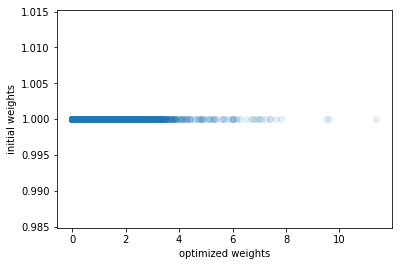

In [0]:
plt.scatter(mrf_weights['wb'],mrf_weights['wb_ini'],alpha=0.1)
plt.xlabel('optimized weights')
plt.ylabel('initial weights')

## Functions for extracting contacts from MRF

In [0]:
###################
def normalize(x):
  x = stats.boxcox(x - np.amin(x) + 1.0)[0]
  x_mean = np.mean(x)
  x_std = np.std(x)
  return((x-x_mean)/x_std)

def get_mtx(mrf):
  '''get mtx given mrf'''
  
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(mrf["w"][:,:-1,:-1]),(1,2)))
  raw_sq = squareform(raw)

  # apc (average product correction)
  ap_sq = np.sum(raw_sq,0,keepdims=True)*np.sum(raw_sq,1,keepdims=True)/np.sum(raw_sq)
  apc = squareform(raw_sq - ap_sq, checks=False)

  mtx = {"i": mrf["w_idx"][:,0],
         "j": mrf["w_idx"][:,1],
         "raw": raw,
         "apc": apc,
         "zscore": normalize(apc)}
  return mtx

def plot_mtx(mtx,key="zscore",vmin=1,vmax=3):
  '''plot the mtx'''
  plt.figure(figsize=(5,5))
  plt.imshow(squareform(mtx[key]), cmap='Blues', interpolation='none', vmin=vmin, vmax=vmax)
  plt.grid(False)
  plt.show()

In [0]:
mtx_weights = get_mtx(mrf_weights)  
#mtx = get_mtx(mrf)
#plot_mtx(mtx)

## Look at top co-evolving residue pairs

In [0]:
######################################################################################
# WARNING - WARNING - WARNING
######################################################################################
# - the i,j index starts at 0 (zero)
# - the "first" position = 0
# - often in biology first position of a sequence is 1
#   for this index use i_aa and j_aa!

# adding amino acid to index
#mtx["i_aa"] = np.array([alphabet[msa['msa_ori'][0][i]]+"_"+str(i+1) for i in mtx["i"]])
#mtx["j_aa"] = np.array([alphabet[msa['msa_ori'][0][j]]+"_"+str(j+1) for j in mtx["j"]])

mtx_weights["i_aa"] = np.array([alphabet[msa['msa_ori'][0][i]]+"_"+str(i+1) for i in mtx_weights["i"]])
mtx_weights["j_aa"] = np.array([alphabet[msa['msa_ori'][0][j]]+"_"+str(j+1) for j in mtx_weights["j"]])


# load mtx into pandas dataframe
#pd_mtx = pd.DataFrame(mtx,columns=["i","j","apc","zscore","i_aa","j_aa"])
pd_mtx_weights = pd.DataFrame(mtx_weights,columns=["i","j","apc","zscore","i_aa","j_aa"])
# get contacts with sequence seperation > 5
# sort by zscore, show top 10
#top = pd_mtx.loc[pd_mtx['j'] - pd_mtx['i'] > 5].sort_values("zscore",ascending=False)
#top.head(10)

In [0]:
def plot_top_n_contacts(df,cor=True):
  
  for index,row in df.nlargest(100,'apc').iterrows():
      if not cor:
        plt.scatter(row.j,row.i,s=row.apc,c='r')
      if cor:
        plt.scatter(row.i,row.j,s=row.apc,c='g')
  plt.axis('square')
  

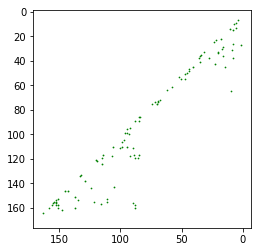

In [0]:

#plot_top_n_contacts(pd_mtx,cor=False)
plot_top_n_contacts(pd_mtx_weights)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

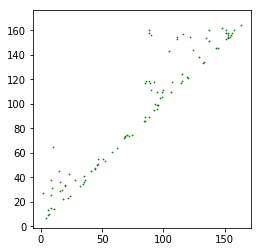

In [0]:
plot_top_n_contacts(pd_mtx_weights)

In [0]:
#pd_mtx.to_csv('pd_mtx_allpdb0777_confirmation.csv')
pd_mtx_weights.to_csv('pd_mtx_allpdb0777_reduced_weights_relu.csv')

## Explore the MRF

In [0]:
def plot_v(mrf):  
  al_a = list(alphabet)
  v = mrf["v"].T
  mx = np.max((v.max(),np.abs(v.min())))
  plt.figure(figsize=(v.shape[1]/4,states/4))
  plt.imshow(-v,cmap='bwr',vmin=-mx,vmax=mx)
  plt.xticks(np.arange(v.shape[1]))
  plt.yticks(np.arange(0,states))
  plt.grid(False)
  ax = plt.gca()
  ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: mrf["v_idx"][x])) 
  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x]))
  
plot_v(mrf)

NameError: ignored

In [0]:
def plot_w(mrf,i,j):
  
  n = int(np.where((mrf["w_idx"][:,0] == i)&(mrf["w_idx"][:,1] == j))[0])
  w = mrf["w"][n]
  
  mx = np.max((w.max(),np.abs(w.min())))
  plt.figure(figsize=(states/4,states/4))
  plt.imshow(-w,cmap='bwr',vmin=-mx,vmax=mx)
  plt.xticks(np.arange(0,states))
  plt.yticks(np.arange(0,states))
  plt.grid(False)
  
  ax = plt.gca()
  al_a = list(alphabet)
  ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x])) 
  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x,y: al_a[x]))
  plt.title(f"W for positions {i} and {j}")
  plt.show()

for n in range(2):
  i = int(top.iloc[n]["i"])
  j = int(top.iloc[n]["j"])
  plot_w(mrf,i,j)

NameError: ignored

## validating output
(comparing to known output from GREMLIN_cpp version)

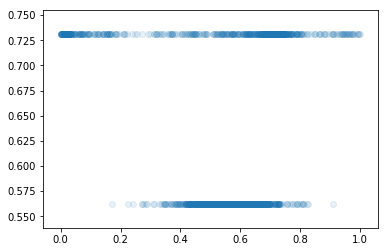

In [0]:
plt.scatter(mrf_weights['wb'],mrf_weights['wb_ini'],alpha=0.1)
#plt.axis('square')

In [0]:
# !wget -q -nc http://files.ipd.uw.edu/krypton/4FAZA.out

In [0]:
# pd_test = pd.read_table("4FAZA.out",sep=" ")
# plt.scatter(pd_test["apc"],mtx["apc"])
# plt.show()

## Useful input features for NN (Neural Networks)

The "apc" values are typically used as input to the NN for contact cleaning or structure prediction. Though in recent advances (aka DeepMind/Alphafold), the entire MRF was used as the input. More specificially LxLx442. The 442 channels are the 21x21 + (raw and/or apc) value.

In [0]:
# w_out = np.zeros((msa["ncol_ori"], msa["ncol_ori"], states * states + 1))
# v_out = np.zeros((msa["ncol_ori"], states))

# mrf_ = np.reshape(mrf["w"],(-1, states * states))
# mtx_ = np.expand_dims(mtx["apc"],-1)

# w_out[(mtx["i"],mtx["j"])] = np.concatenate((mrf_, mtx_),-1)
# w_out += np.transpose(w_out,(1,0,2))
# v_out[mrf["v_idx"]] = mrf["v"]

# print("w_out",w_out.shape)
# print("v_out",v_out.shape)